In [6]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
# set default matplotlib parameters for better aesthetics
plt.rcParams['figure.figsize'] = (10, 6)
# fontsize
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['lines.linewidth'] = 2

# ============================================================
# SET YOUR DATA PATH HERE
# ============================================================
# PTH = r'D:\DATA\g5ht-free\20251223'
# FN = 'date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'  # without .h5 extension

PTH = r'D:\DATA\g5ht-free\20251028'
FN = 'date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'  # without .h5 extension

# PTH = r'D:\DATA\g5ht-free\20260123'
# FN = 'date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004'  # without .h5 extension

# PTH = r'D:\DATA\g5ht-free\20251121'
# FN = 'date-20251121_strain-ISg5HT_condition-fedpatch_worm001'

# PTH = r'D:\DATA\g5ht-free\20251106'
# FN = 'date-20251106_strain-ISg5HT_condition-fedpatch_worm001'

# PTH = r'D:\DATA\g5ht-free\20260113'
# FN = 'date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004'

# PTH = r'D:\DATA\g5ht-free\20260114'
# FN = 'date-20260114_strain-ISg5HT_condition-starvedpatch_worm001'

h5_path = os.path.join(PTH, FN + '.h5')

# Number of z-slices per confocal volume
N_STACK = 41

print(f"Looking for: {h5_path}")
print(f"File exists: {os.path.exists(h5_path)}")

Looking for: D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001.h5
File exists: True


In [7]:
def print_h5_structure(h5_path):
    """Recursively print all datasets and groups in an HDF5 file."""
    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  {name:40s} shape={str(obj.shape):20s} dtype={obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"  {name}/  (group)")

    with h5py.File(h5_path, 'r') as f:
        print(f"\nHDF5 file structure: {h5_path}\n")
        f.visititems(visitor)
        
        # Key checks
        print("\n--- Key Dataset Info ---")
        if 'img_nir' in f:
            shape = f['img_nir'].shape
            print(f"  img_nir: {shape}  (n_frames={shape[0] if len(shape)==3 else shape[2]})")
        else:
            print("  ⚠ img_nir NOT FOUND")
            
        if 'daqmx_ai' in f:
            print(f"  daqmx_ai: {f['daqmx_ai'].shape}")
        else:
            print("  ⚠ daqmx_ai NOT FOUND")
            
        if 'daqmx_di' in f:
            print(f"  daqmx_di: {f['daqmx_di'].shape}")
        else:
            print("  ⚠ daqmx_di NOT FOUND")
            
        if 'img_metadata' in f:
            for key in f['img_metadata'].keys():
                print(f"  img_metadata/{key}: {f['img_metadata'][key].shape}")
        else:
            print("  ⚠ img_metadata NOT FOUND")

print_h5_structure(h5_path)


HDF5 file structure: D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001.h5

  daqmx_ai                                 shape=(3, 3279931)         dtype=float64
  daqmx_di                                 shape=(2, 3279948)         dtype=uint32
  img_metadata/  (group)
  img_metadata/img_id                      shape=(25854,)             dtype=int64
  img_metadata/img_timestamp               shape=(25854,)             dtype=int64
  img_metadata/q_iter_save                 shape=(25854,)             dtype=uint8
  img_metadata/q_recording                 shape=(25854,)             dtype=uint8
  img_nir                                  shape=(12927, 732, 968)    dtype=uint8
  pos_feature                              shape=(12927, 3, 3)        dtype=float32
  pos_stage                                shape=(12927, 2)           dtype=float64
  recording_start                          shape=()                   dtype=|S23

--- Key Dataset Info ---
 

pos_stage shape: (12927, 2)


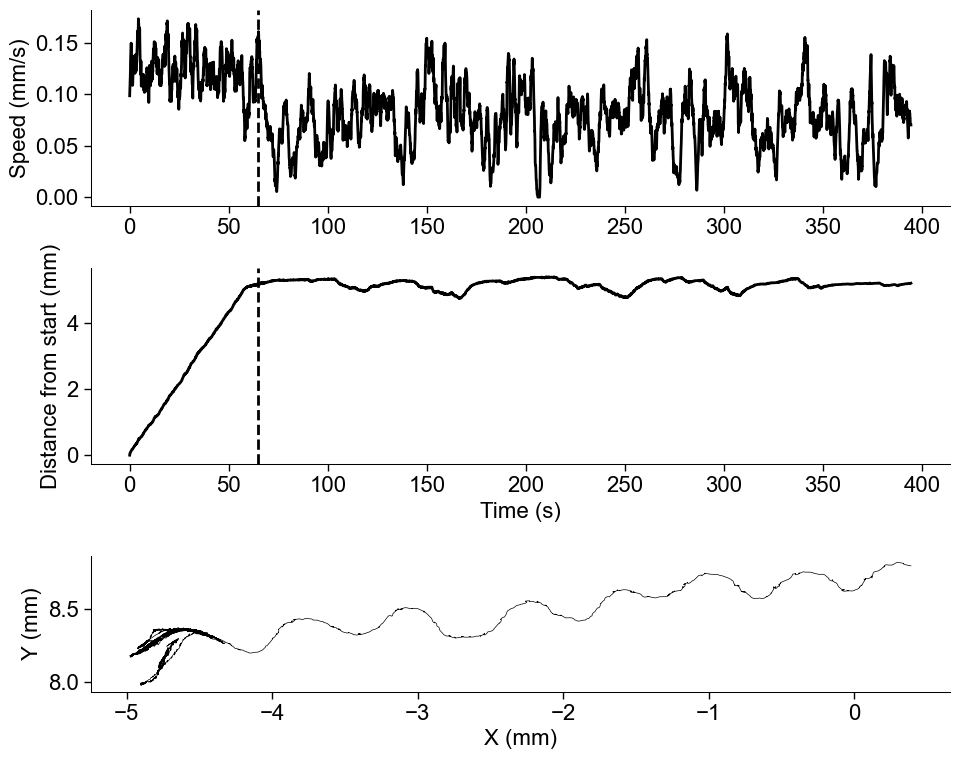

Total frames: 12927
Valid frames: 7889 (61.0%)
Duration: 394.4 s (6.6 min)
Mean speed: 0.0839 mm/s
Total distance: 5.21 mm


In [44]:
%matplotlib inline
import matplotlib
plt.close('all')

fontsize = 20

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': fontsize})
plt.rcParams['svg.fonttype'] = 'none'


# --- Speed from pos_stage ---
STAGE_UNIT = 5500

# --- Time axis ---
# Stage is saved on odd loop_count iterations at LOOP_INTERVAL_CONTROL=40 Hz
# From loop_main: stage channel gets a put! on every odd iteration → ~20 Hz
STAGE_SAVE_RATE = 20.0  # Hz (LOOP_INTERVAL_SAVE_STAGE from constant.jl)
dt = 1.0 / STAGE_SAVE_RATE  # seconds per stage sample

with h5py.File(h5_path, 'r') as f:
    pos_stage = f['pos_stage'][:]  # saved as (2, n_t) from Julia

# Julia saves as (2, n_t), h5py reads column-major, so check shape
print(f"pos_stage shape: {pos_stage.shape}")

# Ensure shape is (n_t, 2) — x,y columns
if pos_stage.shape[0] == 2:
    pos_stage = pos_stage.T  # now (n_t, 2)

# --- Remove NaN frames (stage read errors set NaN in gui_loop.jl) ---
valid = ~np.isnan(pos_stage).any(axis=1)
pos_valid = pos_stage[valid]
valid_idx = np.where(valid)[0]

# --- Stage unit to mm conversion ---
# From gui_loop.jl: covert_stage_unit_to_mm() is applied to stage values.
# You need to set this to match your setup. Common Zaber/similar stages use
# a microstep-to-mm factor. Check your Julia code for covert_stage_unit_to_mm.
# Placeholder — REPLACE with your actual conversion:
def convert_stage_unit_to_mm(val):
    # e.g., for Zaber stages: 1 microstep = 0.047625 µm → 4.7625e-5 mm
    # The /2 in read_position is already applied before saving
    return val / STAGE_UNIT  # <-- REPLACE with your actual factor

pos_mm = convert_stage_unit_to_mm(pos_valid)  # (n_valid, 2) in mm

# --- Instantaneous speed (mm/s) ---
# Mirrors gui_loop.jl:
#   Δstage = norm(cb_last.val .- cb_first.val, 2)
#   speed_worm_stage = Δstage / Δt_cb
#   speed_worm_mm = covert_stage_unit_to_mm(speed_worm_stage)
dx = np.diff(pos_mm, axis=0)  # (n-1, 2)
displacement_mm = np.linalg.norm(dx, axis=1)  # Euclidean distance per step
speed_mm_s = displacement_mm / dt  # mm/s

# --- Smoothed speed (~1s window, matching speed_cb circular buffer) ---
# gui_loop.jl uses a CircularBuffer of size ceil(Int, (1/20^-1)/2) = ceil(10) = 10
# It computes speed as total displacement / total time over the buffer window
window_size = 30  # ~0.5s at 20 Hz, matching the circular buffer size
speed_smooth = np.convolve(speed_mm_s, np.ones(window_size) / window_size, mode='same')

# --- Time axis for speed ---
time_s = np.arange(len(speed_mm_s)) * dt

# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(10,8))

tick_dir = 'out'
tick_length=5
tick_width=1
spine_width=0.75
fontsize=20
top_border=False
right_border=False

for ax in axes:
    ax.tick_params(direction=tick_dir, length=tick_length, width=tick_width)
    for spine in ax.spines.values():
        spine.set_linewidth(spine_width)
    if not top_border:
        ax.spines['top'].set_visible(False)
    if not right_border:
        ax.spines['right'].set_visible(False)

# Speed
# axes[0].plot(time_s, speed_mm_s, alpha=0.3, color='gray', label='Instantaneous')
axes[0].plot(time_s, speed_smooth, color='black', linewidth=2, label=f'Smoothed ({window_size}-sample avg)')
axes[0].set_ylabel('Speed (mm/s)')
# axes[0].set_title('Worm Speed from Stage Position')
axes[0].axvline(65, color='black', linestyle='--', label='encounter')

# Cumulative displacement
# cumulative_dist = np.cumsum(displacement_mm)
# # axes[1].plot(time_s, cumulative_dist, color='blue')
# axes[1].set_ylabel('Cumulative distance (mm)')
# axes[1].set_xlabel('Time (s)')

# calculate and plot distance from start
start_pos = pos_mm[0]
dist_from_start = np.linalg.norm(pos_mm - start_pos, axis=1)
axes[1].plot(time_s, dist_from_start[:len(time_s)], color='black')
axes[1].axvline(65, color='black', linestyle='--', label='encounter')
# axes[1].legend(['Cumulative distance', 'Distance from start'])
axes[1].set_ylabel('Distance from start (mm)')
axes[1].set_xlabel('Time (s)')

# Trajectory
axes[2].plot(pos_mm[:, 0], pos_mm[:, 1], linewidth=0.5, color='black')
axes[2].set_xlabel('X (mm)')
axes[2].set_ylabel('Y (mm)')
# axes[2].set_title('Stage Trajectory')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"Total frames: {pos_stage.shape[0]}")
print(f"Valid frames: {pos_valid.shape[0]} ({100*pos_valid.shape[0]/pos_stage.shape[0]:.1f}%)")
print(f"Duration: {time_s[-1]:.1f} s ({time_s[-1]/60:.1f} min)")
print(f"Mean speed: {np.nanmean(speed_smooth):.4f} mm/s")
print(f"Total distance: {dist_from_start[-1]:.2f} mm")

In [75]:
# Quick visualization of the signals used for synchronization

%matplotlib qt

plt.close('all')

lw = 2

with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]
    recording_start = f['recording_start'][()]

n_index = daqmx_ai.shape[1]

# for each signal, concatenate in time, the first N and the last N samples, to visualize the beginning and end of the recording in one plot
# pad with NaNs in between to separate the two segments visually
Npad_pre = 10000 # skip the first 10000 samples, which are very noisy and not useful for visualization
Npre = 40000
Npost = 100000
Npad = 5000
signal_segments_ai = []
signal_segments_di = []
for i in range(daqmx_ai.shape[0]):
    signal = daqmx_ai[:, i] if daqmx_ai.shape[0] > daqmx_ai.shape[1] else daqmx_ai[i, :]
    segment = np.concatenate((signal[Npad_pre:Npad_pre+Npre], np.full(Npad, np.nan), signal[-Npost:]))
    signal_segments_ai.append(segment)
for i in range(daqmx_di.shape[0]):
    signal = daqmx_di[:, i] if daqmx_di.shape[0] > daqmx_di.shape[1] else daqmx_di[i, :]
    segment = np.concatenate((signal[Npad_pre:Npad_pre+Npre], np.full(Npad, np.nan), signal[-Npost:]))
    signal_segments_di.append(segment)

fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)

labels = [
    ('daqmx_ai col 0', 'Laser Signal', 'orange'),
    ('daqmx_ai col 1', 'Piezo Signal', 'blue'),
    ('daqmx_di col 0', 'Confocal Camera DI', 'green'),
    ('daqmx_di col 1', 'NIR Camera DI', 'red'),
]

# plot the analog and digital signal segments
for i in range(2):
    axes[i].plot(signal_segments_ai[i], color=labels[i][2], linewidth=lw)
    axes[i].set_ylabel(labels[i][1])
    axes[i].set_title(labels[i][0])
for i in range(2):
    axes[i+2].plot(signal_segments_di[i], color=labels[i+2][2], linewidth=lw)
    axes[i+2].set_ylabel(labels[i+2][1])
    axes[i+2].set_title(labels[i+2][0])

# # Plot analog inputs
# for i in range(2):
#     axes[i].plot(daqmx_ai[i, index2plot[0]:index2plot[1]] if daqmx_ai.shape[0] < daqmx_ai.shape[1] else daqmx_ai[index2plot[0]:index2plot[1], i],
#                  color=labels[i][2], linewidth=lw)
#     axes[i].set_ylabel(labels[i][1])
#     axes[i].set_title(labels[i][0])

# # Plot digital inputs
# for i in range(2):
#     axes[i+2].plot(daqmx_di[i, index2plot[0]:index2plot[1]] if daqmx_di.shape[0] < daqmx_di.shape[1] else daqmx_di[index2plot[0]:index2plot[1], i],
#                    color=labels[i+2][2], linewidth=lw)
#     axes[i+2].set_ylabel(labels[i+2][1])
#     axes[i+2].set_title(labels[i+2][0])

axes[-1].set_xlabel('Sample index')
plt.tight_layout()
plt.show()

print(f"\ndaqmx_ai shape: {daqmx_ai.shape}")
print(f"daqmx_di shape: {daqmx_di.shape}")
print(f"recording_start: {recording_start}")


daqmx_ai shape: (3, 3261997)
daqmx_di shape: (2, 3262014)
recording_start: b'2026-01-14T15:35:49.887'


# V3

### FUNCTIONS

In [25]:
# Assuming 'signal' is your numpy array 
# and 'peaks' is your array of peak indices
def find_wave_starts(signal, peaks):
    starts = []
    
    for i in range(len(peaks)):
        if i == 0:
            # For the first peak, search from the beginning of the signal
            start_idx = np.argmin(signal[:peaks[i]])
        else:
            # Search between the previous peak and current peak
            search_range = signal[peaks[i-1] : peaks[i]]
            # Add the offset of the previous peak to get the absolute index
            start_idx = np.argmin(search_range) + peaks[i-1]
            
        starts.append(start_idx)
        
    return np.array(starts)

# Example usage:
# start_indices = find_wave_starts(my_signal, peak_indices)

def map_timestamps(source_timing, reference_timing):
    """
    Finds which interval in reference_timing each source_start falls into.
    Assumes reference_timing is sorted by start times.
    """
    # Extract start times for binary search
    ref_starts = reference_timing[:, 0]
    ref_stops = reference_timing[:, 1]
    source_starts = source_timing[:, 0]

    # Find the index where each source_start would fit in ref_starts
    # 'side=right' - 1 gives us the index j such that ref_starts[j] <= source_start
    idx = np.searchsorted(ref_starts, source_starts, side='right') - 1

    # Validation: Check if it actually falls within the [start, stop] window
    # If the index is -1 or source_start > stop, it doesn't fit any interval
    mask = (idx >= 0) & (source_starts <= ref_stops[idx])
    
    # Create result array (NaN for no match, 1-based indexing for matches)
    result = np.full(source_starts.shape[0], np.nan)
    result[mask] = idx[mask] + 1
    
    return result

def generate_consecutive_counts(arr):
    # Ensure input is a numpy array
    arr = np.asarray(arr)
    
    # Identify where the values change (the first element is always a change)
    # np.diff returns an array of differences between consecutive elements
    # We check where that difference is not zero
    change_indices = np.where(arr[:-1] != arr[1:])[0] + 1
    
    # Create an array of zeros to store the result
    res = np.zeros(len(arr), dtype=int)
    
    # The starting positions of each new group are at index 0 and 
    # all positions identified by change_indices
    starts = np.concatenate(([0], change_indices))
    
    # For each group, we subtract the start index from the current index
    # to get the running count: [0, 1, 2, ...]
    for i in range(len(starts)):
        start = starts[i]
        end = starts[i+1] if i + 1 < len(starts) else len(arr)
        res[start:end] = np.arange(end - start)
        
    return res

# # Example usage:
# arr = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 5, 5, 5, 5])
# print(generate_consecutive_counts(arr))
# # Output: [0 1 2 3 4 0 1 2 3 4 0 1 2 3]

### Plot all DAQ signals together

session.list_cam_info contains img_metadata

It's using spinnaker.jl, so it's probably time since hardware powered on (img_timestamp)
and it's probably in nanoseconds

In [45]:
from scipy.signal import find_peaks
%matplotlib qt

plt.close('all')

N_STACK = 41

NIDAQ_SAMPLE_RATE_AI = 5000.0 # Hz
CONTROL_NIR_FPS = 40.0
SAVE_NIR_FPS = 20.0

with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]
    n_img_nir = f['img_nir'].shape[0]
    img_metadata = f['img_metadata']
    img_timestamp = img_metadata['img_timestamp'][:]
    img_id = img_metadata["img_id"][:]
    q_iter_save = img_metadata["q_iter_save"][:]


di_confocal = daqmx_di[0,:].astype(np.float32)
di_nir = daqmx_di[1,:].astype(np.float32)
ai_laser = daqmx_ai[0,:].astype(np.float32)
ai_piezo = daqmx_ai[1,:].astype(np.float32)
# ai_stim = daqmx_ai[2,:].astype(np.float32)
img_timestamp_sec = (img_timestamp - img_timestamp[0]) / 1e9

di_confocal_rise = np.where(np.diff(di_confocal) > 0.0)[0] + 1

confocal_on_sample = np.where(np.diff(ai_laser) > 0.5)[0] + 1 # find rising edges (laser on)
confocal_start_sample_ai = confocal_on_sample[0] # get first rising edge, which should correspond to confocal recording start
confocal_off_sample = np.where(np.diff(ai_laser) < -0.5)[0] + 1 # find falling edges (laser off)
confocal_stop_sample_ai = confocal_off_sample[1] # get second falling edge, which should correspond to confocal recording stop, first falling edge is at the beginning of the recording (see plots related to ai_laser)

peaks, properties = find_peaks(
    ai_piezo, 
    distance=100,
    prominence=1.0
) # find peaks in piezo signal, which should correspond to stack acquisition. distance is set to 400 samples
stack_start_sample = peaks.copy() + 150 # +20 for visualization only
stack_start_sample = np.insert(stack_start_sample, 0, confocal_start_sample_ai)  # prepend first element as confocal recording start
stack_start_sample = stack_start_sample[:-1]  # delete last element

stack_stop_sample = peaks.copy()
stack_stop_sample[-1] = confocal_stop_sample_ai # set last stack stop to confocal recording stop
piezo_timing = np.concatenate((stack_start_sample.reshape(-1,1), stack_stop_sample.reshape(-1,1)), axis=1) # combine piezo start and stop indices to get confocal stack timing

# zoom = (0, 60000)
# zoom = (3257743-100000,3257743)
zoom = (0, len(ai_laser)-1)

time = np.arange(len(ai_laser)) / NIDAQ_SAMPLE_RATE_AI

fig, axs = plt.subplots(4, 1, figsize=(15,6), sharex=True)
axs[0].plot(time[zoom[0]:zoom[1]], ai_laser[zoom[0]:zoom[1]], label='Laser Signal', color='orange')
axs[1].plot(time[zoom[0]:zoom[1]], ai_piezo[zoom[0]:zoom[1]], label='Piezo Signal', color='blue')
axs[2].plot(time[zoom[0]:zoom[1]], di_confocal[zoom[0]:zoom[1]], label='Confocal Camera DI', color='green')
axs[3].plot(time[zoom[0]:zoom[1]], di_nir[zoom[0]:zoom[1]], label='NIR Camera DI', color='magenta')

# plot every 41st di_confocal_rise index as vertical lines to see if they align with confocal stack timing
# this is the start of the next confocal stack
for idx in di_confocal_rise[::41]:
    if zoom[0] <= idx < zoom[1]:
        axs[2].axvline(x=time[idx]-time[zoom[0]], color='black', linestyle='-')

# plot confocal recording start and stop
axs[0].axvline(x=time[confocal_start_sample_ai]-time[zoom[0]], color='black', linestyle='--')
axs[0].axvline(x=time[confocal_stop_sample_ai]-time[zoom[0]], color='black', linestyle='--')

# plot stack start and stops as vertical lines to see if they align with confocal stack timing
for (start,stop) in zip(piezo_timing[:,0], piezo_timing[:,1]):
    if zoom[0] <= start < zoom[1]:
        axs[1].axvline(x=time[start]-time[zoom[0]], color='green', linestyle='-')
    if zoom[0] <= stop < zoom[1]:
        axs[1].axvline(x=time[stop]-time[zoom[0]], color='red', linestyle='-')

plt.xlim(0, time[zoom[1]]-time[zoom[0]])
plt.xlabel('Time (seconds)')
plt.tight_layout()
plt.show()



IndexError: index 1 is out of bounds for axis 0 with size 0

In [ ]:
from scipy.signal import find_peaks
%matplotlib qt

plt.close('all')

N_STACK = 41

NIDAQ_SAMPLE_RATE_AI = 5000.0 # Hz
CONTROL_NIR_FPS = 40.0
SAVE_NIR_FPS = 20.0

with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]
    n_img_nir = f['img_nir'].shape[0]
    img_metadata = f['img_metadata']
    img_timestamp = img_metadata['img_timestamp'][:]
    img_id = img_metadata["img_id"][:]
    q_iter_save = img_metadata["q_iter_save"][:]


di_confocal = daqmx_di[0,:].astype(np.float32)
di_nir = daqmx_di[1,:].astype(np.float32)
ai_laser = daqmx_ai[0,:].astype(np.float32)
ai_piezo = daqmx_ai[1,:].astype(np.float32)
# ai_stim = daqmx_ai[2,:].astype(np.float32)

di_confocal_rise = np.where(np.diff(di_confocal) > 0.0)[0] + 1

confocal_on_sample = np.where(np.diff(ai_laser) > 0.5)[0] + 1 # find rising edges (laser on)
confocal_start_sample_ai = confocal_on_sample[0] # get first rising edge, which should correspond to confocal recording start
confocal_off_sample = np.where(np.diff(ai_laser) < -0.5)[0] + 1 # find falling edges (laser off)
confocal_stop_sample_ai = confocal_off_sample[1] # get second falling edge, which should correspond to confocal recording stop, first falling edge is at the beginning of the recording (see plots related to ai_laser)

peaks, properties = find_peaks(
    ai_piezo, 
    distance=100,
    prominence=1.0
) # find peaks in piezo signal, which should correspond to stack acquisition. distance is set to 400 samples
stack_start_sample = peaks.copy() + 150 # +20 for visualization only
stack_start_sample = np.insert(stack_start_sample, 0, confocal_start_sample_ai)  # prepend first element as confocal recording start
stack_start_sample = stack_start_sample[:-1]  # delete last element

stack_stop_sample = peaks.copy()
stack_stop_sample[-1] = confocal_stop_sample_ai # set last stack stop to confocal recording stop
piezo_timing = np.concatenate((stack_start_sample.reshape(-1,1), stack_stop_sample.reshape(-1,1)), axis=1) # combine piezo start and stop indices to get confocal stack timing

# zoom = (0, 60000)
# zoom = (3257743-100000,3257743)
zoom = (0, len(ai_laser))


fig, axs = plt.subplots(4, 1, figsize=(15,6), sharex=True)
axs[0].plot(ai_laser[zoom[0]:zoom[1]], label='Laser Signal', color='orange')
axs[1].plot(ai_piezo[zoom[0]:zoom[1]], label='Piezo Signal', color='blue')
axs[2].plot(di_confocal[zoom[0]:zoom[1]], label='Confocal Camera DI', color='green')
axs[3].plot(di_nir[zoom[0]:zoom[1]], label='NIR Camera DI', color='magenta')

# plot every 41st di_confocal_rise index as vertical lines to see if they align with confocal stack timing
# this is the start of the next confocal stack
for idx in di_confocal_rise[::41]:
    if zoom[0] <= idx < zoom[1]:
        axs[2].axvline(x=idx-zoom[0], color='black', linestyle='-')

# plot confocal recording start and stop
axs[0].axvline(x=confocal_start_sample_ai-zoom[0], color='black', linestyle='--')
axs[0].axvline(x=confocal_stop_sample_ai-zoom[0], color='black', linestyle='--')

# plot stack start and stops as vertical lines to see if they align with confocal stack timing
for (start,stop) in zip(piezo_timing[:,0], piezo_timing[:,1]):
    if zoom[0] <= start < zoom[1]:
        axs[1].axvline(x=start-zoom[0], color='green', linestyle='-')
    if zoom[0] <= stop < zoom[1]:
        axs[1].axvline(x=stop-zoom[0], color='red', linestyle='-')

plt.xlim(0, zoom[1]-zoom[0])
plt.xlabel('Sample index')
plt.tight_layout()
plt.show()



### AI Confocal plots

In [ ]:
%matplotlib qt

from scipy.stats import mode
from sync import detect_nir_timing
from scipy.signal import find_peaks


with h5py.File(h5_path, 'r') as f:
    ai_laser = f['daqmx_ai'][:][0,:].astype(np.float32)

# get confocal recording start and stop times
#   when ai_laser goes from 0 to 1, recording on
#   when ai_laser goes from 1 to 0, recording off
#   note: there is additional on/off signlas after recording off in ai_laser, this corresponds to nir recording, not getting those timestamps
confocal_on_sample = np.where(np.diff(ai_laser) > 0.5)[0] + 1 # find rising edges (laser on)
confocal_on_sample = confocal_on_sample[0] # get first rising edge, which should correspond to confocal recording start
confocal_off_sample = np.where(np.diff(ai_laser) < -0.5)[0] + 1 # find falling edges (laser off)
confocal_off_sample = confocal_off_sample[1] # get second falling edge, which should correspond to confocal recording stop, first falling edge is at the beginning of the recording (see plots related to ai_laser)



fig, axs = plt.subplots(2, 1, figsize=(11, 4), sharex=True)
axs[0].plot(ai_laser, label='AI confocal (Start)', color='orange')
axs[0].plot(confocal_on_sample, ai_laser[confocal_on_sample], 'go', label='Confocal On')
axs[0].plot(confocal_off_sample, ai_laser[confocal_off_sample], 'ro', label='Confocal Off')
axs[0].legend()
axs[1].plot(np.diff(ai_laser))
plt.show()

### DI Confocal plots

In [27]:
with h5py.File(h5_path, 'r') as f:
    di_confocal = f['daqmx_di'][:][0,:].astype(np.float32)

# get stack start (rise) and stop (fall) indices from di_confocal , which is the digital input from the confocal camera that should indicate when each stack starts and stops.
di_confocal_rise = np.where(np.diff(di_confocal) > 0.0)[0] + 1
di_confocal_fall = np.where(np.diff(di_confocal) < 0.0)[0] + 1
confocal_start_sample_di = di_confocal_rise[0] # recording start in confocal
confocal_timing = np.concatenate((di_confocal_rise.reshape(-1,1), di_confocal_fall.reshape(-1,1)), axis=1) # combine confocal rise and fall indices to get confocal stack timing


fig, axs = plt.subplots(2, 1, figsize=(11, 4), sharex=True)
axs[0].plot(di_confocal, label='DI confocal', color='orange')
axs[0].plot(confocal_start_sample_di, di_confocal[confocal_start_sample_di], 'go', label='Confocal On')
axs[0].legend()
axs[1].plot(np.diff(di_confocal))
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(11, 4), sharex=True)
axs[0].plot(di_confocal, label='DI confocal', color='orange')
axs[0].plot(di_confocal_rise, di_confocal[di_confocal_rise], 'go', label='Confocal Stack Start')
axs[0].plot(di_confocal_fall, di_confocal[di_confocal_fall], 'ro', label='Confocal Stack Stop')
axs[0].legend()
axs[1].plot(np.diff(di_confocal))
plt.show()

c:\Users\munib\anaconda3\envs\imgpro\Lib\site-packages\ipykernel\eventloops.py:145: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  el.exec() if hasattr(el, "exec") else el.exec_()


### DI NIR plots

In [28]:
%matplotlib qt

N_STACK = 41

NIDAQ_SAMPLE_RATE_AI = 5000.0 # Hz
CONTROL_NIR_FPS = 40.0
SAVE_NIR_FPS = 20.0

with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]
    n_img_nir = f['img_nir'].shape[0]
    img_metadata = f['img_metadata']
    img_timestamp = img_metadata['img_timestamp'][:]
    img_id = img_metadata["img_id"][:]
    q_iter_save = img_metadata["q_iter_save"][:]


di_confocal = daqmx_di[0,:].astype(np.float32)
di_nir = daqmx_di[1,:].astype(np.float32)
ai_laser = daqmx_ai[0,:].astype(np.float32)
ai_piezo = daqmx_ai[1,:].astype(np.float32)
# ai_stim = daqmx_ai[2,:].astype(np.float32)
img_timestamp_sec = (img_timestamp - img_timestamp[0]) / 1e9

list_nir_on  = np.where(np.diff(di_nir) >  1)[0] + 1
list_nir_off = np.where(np.diff(di_nir) < -1)[0] + 1

total_expected = int(np.sum(np.diff(img_id)))

print(f"Total triggers detected (raw): {len(list_nir_on)}")
print(f"Total expected from img_id:     {total_expected}")
print(f"Mismatch:                       {len(list_nir_on) - total_expected}")
print(f"Saved frames (n_img_nir):       {n_img_nir}")
print(f"Sum of q_iter_save:             {np.sum(q_iter_save)}")

# Check the recording window detection
gaps = np.diff(list_nir_on)
large_gaps = np.where(gaps > 500)[0]
print(f"\nLarge gaps (>500 samples) at indices: {large_gaps}")
print(f"Gap sizes: {gaps[large_gaps]}")

# Plot to visually inspect
plt.figure(figsize=(16, 4))
plt.plot(di_nir, color='magenta')
for g in large_gaps:
    plt.axvline(list_nir_on[g], color='red', linestyle='--', alpha=0.7)
    plt.axvline(list_nir_on[g+1], color='green', linestyle='--', alpha=0.7)
plt.title('NIR digital signal with large gaps marked')
plt.show()

Total triggers detected (raw): 25947
Total expected from img_id:     25966
Mismatch:                       -19
Saved frames (n_img_nir):       12780
Sum of q_iter_save:             12780

Large gaps (>500 samples) at indices: [25945]
Gap sizes: [3803]


In [41]:
# isolated detect nir timing code for testing
%matplotlib qt

import sys
import importlib
_ = importlib.reload(sys.modules['sync'])

plt.close('all')

N_STACK = 41

NIDAQ_SAMPLE_RATE_AI = 5000.0 # Hz
CONTROL_NIR_FPS = 40.0
SAVE_NIR_FPS = 20.0

with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]
    n_img_nir = f['img_nir'].shape[0]
    img_metadata = f['img_metadata']
    img_timestamp = img_metadata['img_timestamp'][:]
    img_id = img_metadata["img_id"][:]
    q_iter_save = img_metadata["q_iter_save"][:]


di_confocal = daqmx_di[0,:].astype(np.float32)
di_nir = daqmx_di[1,:].astype(np.float32)
ai_laser = daqmx_ai[0,:].astype(np.float32)
ai_piezo = daqmx_ai[1,:].astype(np.float32)
# ai_stim = daqmx_ai[2,:].astype(np.float32)
img_timestamp_sec = (img_timestamp - img_timestamp[0]) / 1e9

# Get recording window from ai_laser (your existing logic)
confocal_on_sample  = np.where(np.diff(ai_laser) > 0.5)[0] + 1
confocal_recording_start     = confocal_on_sample[0]
confocal_off_sample = np.where(np.diff(ai_laser) < -0.5)[0] + 1
confocal_recording_stop      = confocal_off_sample[1]


# Find all trigger edges
list_nir_on  = np.where(np.diff(di_nir) >  1)[0] + 1
list_nir_off = np.where(np.diff(di_nir) < -1)[0] + 1

nir_record_on  = np.diff(list_nir_on)  > 500
nir_record_off = np.diff(list_nir_off) > 500

# --- recording start ---
if list_nir_on[0] > 500:
    s_nir_start = list_nir_on[0]
elif np.sum(nir_record_on) == 2:
    s_nir_start = list_nir_on[np.where(nir_record_on)[0][0] + 1]
else:
    raise ValueError(
        "More than 2 recording-on transitions detected for FLIR camera"
    )

# --- recording stop ---
if list_nir_off[-1] < len(di_nir) - 500:
    s_nir_stop = list_nir_off[-1]
elif np.sum(nir_record_off) <= 2:
    s_nir_stop = list_nir_off[
        np.where(np.diff(list_nir_off) > 500)[0][-1]
    ]
else:
    raise ValueError(
        "More than 2 recording-off transitions detected for FLIR camera"
    )
    
# Keep triggers inside the recording window (±5 samples tolerance)
mask_on  = (s_nir_start - 5 < list_nir_on)  & (list_nir_on  < s_nir_stop + 5)
mask_off = (s_nir_start - 5 < list_nir_off) & (list_nir_off < s_nir_stop + 5)
list_nir_on  = list_nir_on[mask_on]
list_nir_off = list_nir_off[mask_off]

# looks good so far

img_id_diff = np.diff(img_id).tolist() # img_id_diff , how many camera triggers happened between consecutive iterations. Usually 1, if >1, that means triggers fired but were not saved (frame skips)
img_id_diff.insert(0, 1)
total_expected = int(np.sum(np.diff(img_id)))

if abs(len(list_nir_on) - total_expected) > 3:
    raise ValueError(
        f"Detected trigger count ({len(list_nir_on)}) differs from "
        f"image-ID count ({total_expected}) by more than 3"
    )
else:
    img_id_diff[-1] += len(list_nir_on) - total_expected - 1

plt.figure(figsize=(12, 4))
plt.plot(di_nir, label='DI NIR', color='magenta')
plt.plot(list_nir_on, di_nir[list_nir_on], 'go', label='NIR On')
plt.plot(list_nir_off, di_nir[list_nir_off], 'ro', label='NIR Off')
plt.axvline(confocal_recording_start, color='blue', linestyle='--', label='Confocal Recording Start')
plt.axvline(confocal_recording_stop, color='red', linestyle='--', label='Confocal Recording Stop')
# plt.legend()
plt.tight_layout()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 0

In [30]:
# plot number of samples between saved nir frames
plt.figure(figsize=(12, 4))
plt.plot(np.diff(img_timestamp[q_iter_save.astype(bool)]))
plt.show()

In [4]:
# plot di nir with img timestamps
%matplotlib qt

plt.close('all')

N_STACK = 41

NIDAQ_SAMPLE_RATE_AI = 5000.0 # Hz
CONTROL_NIR_FPS = 40.0
SAVE_NIR_FPS = 20.0

with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]
    n_img_nir = f['img_nir'].shape[0]
    img_metadata = f['img_metadata']
    img_timestamp = img_metadata['img_timestamp'][:]
    img_id = img_metadata["img_id"][:]
    q_iter_save = img_metadata["q_iter_save"][:]


di_confocal = daqmx_di[0,:].astype(np.float32)
di_nir = daqmx_di[1,:].astype(np.float32)
ai_laser = daqmx_ai[0,:].astype(np.float32)
ai_piezo = daqmx_ai[1,:].astype(np.float32)
# ai_stim = daqmx_ai[2,:].astype(np.float32)

# Find all trigger edges
list_nir_on  = np.where(np.diff(di_nir) >  1)[0] + 1
list_nir_off = np.where(np.diff(di_nir) < -1)[0] + 1

nir_record_on  = np.diff(list_nir_on)  > 500
nir_record_off = np.diff(list_nir_off) > 500

# --- recording start ---
if list_nir_on[0] > 500:
    s_nir_start = list_nir_on[0]
elif np.sum(nir_record_on) == 2:
    s_nir_start = list_nir_on[np.where(nir_record_on)[0][0] + 1]
else:
    raise ValueError(
        "More than 2 recording-on transitions detected for FLIR camera"
    )

# --- recording stop ---
if list_nir_off[-1] < len(di_nir) - 500:
    s_nir_stop = list_nir_off[-1]
elif np.sum(nir_record_off) <= 2:
    s_nir_stop = list_nir_off[
        np.where(np.diff(list_nir_off) > 500)[0][-1]
    ]
else:
    raise ValueError(
        "More than 2 recording-off transitions detected for FLIR camera"
    )
    
# Keep triggers inside the recording window (±5 samples tolerance)
mask_on  = (s_nir_start - 5 < list_nir_on)  & (list_nir_on  < s_nir_stop + 5)
mask_off = (s_nir_start - 5 < list_nir_off) & (list_nir_off < s_nir_stop + 5)
list_nir_on  = list_nir_on[mask_on]
list_nir_off = list_nir_off[mask_off]



img_timestamp_sec = (img_timestamp - img_timestamp[0]) / 1e9 + (list_nir_on[0]/NIDAQ_SAMPLE_RATE_AI) # 0.1617 #+ 0.1798

img_timestamp_sec_saved = img_timestamp_sec[q_iter_save.astype(bool)]

time = np.arange(len(di_nir)) / NIDAQ_SAMPLE_RATE_AI

plt.figure(figsize=(12, 4))
plt.plot(time, di_nir, label='DI NIR', color='magenta')
# plot vertical lines for img_timestamp_sec
for ts in img_timestamp_sec_saved:
    plt.axvline(ts, color='black', linestyle='-', alpha=1.0)

plt.xlabel('Time (s)')
plt.ylabel('DI NIR')
plt.title('NIR Digital Signal with Image Timestamps')
# plt.legend()
plt.tight_layout()
plt.show()


## MAIN

In [46]:
# main code

from scipy.stats import mode
from sync import detect_nir_timing
from scipy.signal import find_peaks

N_STACK = 41

NIDAQ_SAMPLE_RATE_AI = 5000.0 # Hz
CONTROL_NIR_FPS = 40.0
SAVE_NIR_FPS = 20.0


with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]
    n_img_nir = f['img_nir'].shape[0]
    img_metadata = f['img_metadata']
    img_timestamp = img_metadata['img_timestamp'][:]
    img_id = img_metadata["img_id"][:]
    q_iter_save = img_metadata["q_iter_save"][:]
        
print(f"Loaded daqmx_ai with shape: {daqmx_ai.shape}")
print(f"Loaded daqmx_di with shape: {daqmx_di.shape}")
print(f"img_id with shape: {img_id.shape}")
print(f"img_timestamp with shape: {img_timestamp.shape}")
print(f"q_iter_save with shape: {q_iter_save.shape}")
print(f"Number of NIR images: {n_img_nir}")

di_confocal = daqmx_di[0,:].astype(np.float32)
di_nir = daqmx_di[1,:].astype(np.float32)
ai_laser = daqmx_ai[0,:].astype(np.float32)
ai_piezo = daqmx_ai[1,:].astype(np.float32)


# # get confocal recording start and stop times
# #   when ai_laser goes from 0 to 1, recording on
# #   when ai_laser goes from 1 to 0, recording off
# #   note: there is additional on/off signlas after recording off in ai_laser, this corresponds to nir recording, not getting those timestamps
# confocal_on_sample = np.where(np.diff(ai_laser) > 0.5)[0] + 1 # find rising edges (laser on)
# confocal_start_sample_ai = confocal_on_sample[0] # get first rising edge, which should correspond to confocal recording start
# confocal_off_sample = np.where(np.diff(ai_laser) < -0.5)[0] + 1 # find falling edges (laser off)
# confocal_stop_sample_ai = confocal_off_sample[1] # get second falling edge, which should correspond to confocal recording stop, first falling edge is at the beginning of the recording (see plots related to ai_laser)

# get stack start (rise) and stop (fall) indices from di_confocal , which is the digital input from the confocal camera that should indicate when each stack starts and stops.
di_confocal_rise = np.where(np.diff(di_confocal) > 0.0)[0] + 1
di_confocal_fall = np.where(np.diff(di_confocal) < 0.0)[0] + 1
confocal_start_sample_di = di_confocal_rise[0] # recording start in confocal
confocal_stop_sample_di = di_confocal_fall[-1] # recording stop in confocal, should be the last falling edge
confocal_timing = np.concatenate((di_confocal_rise.reshape(-1,1), di_confocal_fall.reshape(-1,1)), axis=1) # combine confocal rise and fall indices to get confocal stack timing

# # confocal_start_idx from di should be the same as confocal_start_idx from ai_laser, which is what we were using before. let's check that.
# assert (confocal_start_sample_ai - confocal_start_sample_di) == 0, "Confocal start index from DI and AI do not match"

# find piezo start stop (fall) times from ai_piezo. ai_piezo is a ramping signal that indicates when the piezo is moving, which should correspond to when the confocal camera is acquiring a stack. we can use this to check if the confocal stack timing from di_confocal matches the piezo movement timing from ai_piezo.
# need to first find the peaks using a peak finding algorithm, since the piezo signal is not a perfect ramp and has some noise. we can use scipy.signal.find_peaks for this.
peaks, properties = find_peaks(
    ai_piezo, 
    distance=100,
    prominence=1.0
) # find peaks in piezo signal, which should correspond to stack acquisition. distance is set to 400 samples
stack_start_sample = peaks.copy()
stack_start_sample = np.insert(stack_start_sample, 0, confocal_start_sample_di)  # prepend first element as confocal recording start
stack_start_sample = stack_start_sample[:-1]  # delete last element

stack_stop_sample = peaks.copy()
stack_stop_sample[-1] = confocal_stop_sample_di # set last stack stop to confocal recording stop
piezo_timing = np.concatenate((stack_start_sample.reshape(-1,1), stack_stop_sample.reshape(-1,1)), axis=1) # combine piezo start and stop indices to get confocal stack timing


# get nir recording start (rise) and stop (fall) indices from di_nir, which is the digital input from the NIR camera that should indicate when each NIR recording starts and stops.
nir_timing = detect_nir_timing(di_nir, img_id, q_iter_save, n_img_nir)
di_nir_rise = nir_timing[:, 0]
di_nir_fall = nir_timing[:, 1]
# di_nir_rise = np.where(np.diff(di_nir) > 0.5)[0]
# di_nir_fall = np.where(np.diff(di_nir) < -0.5)[0]
nir_start_idx = di_nir_rise[0] # recording start in NIR

# validated this with working recording, that passed detect_nir_timing's checks
# for recordings that don't pass, might have to trim out some img_timstamps at end of recording that seem to be artifacts, but not totally sure
img_timestamp_sec = (img_timestamp - img_timestamp[0]) / 1e9 + (nir_start_idx/NIDAQ_SAMPLE_RATE_AI)
img_timestamp_sec_saved = img_timestamp_sec[q_iter_save.astype(bool)]


# # we have confocal_timing, piezo_timing, nir_timing
# let's  now map them

# 1. Confocal to Piezo mapping (which confocal stack corresponds each di_confocal corresonds to)
confocal_to_piezo_mapping = map_timestamps(confocal_timing, piezo_timing)

# 2. NIR to Piezo mapping (which confocal stack corresponds to each nir frame)
nir_to_piezo_mapping = map_timestamps(nir_timing, piezo_timing)

# 3. NIR to Confocal mapping ()
nir_to_confocal_mapping = map_timestamps(nir_timing, confocal_timing)

# 4. Plane number 
confocal_plane = generate_consecutive_counts(confocal_to_piezo_mapping)



Loaded daqmx_ai with shape: (4, 619244)
Loaded daqmx_di with shape: (2, 619260)
img_id with shape: (4825,)
img_timestamp with shape: (4825,)
q_iter_save with shape: (4825,)
Number of NIR images: 2412


In [52]:
# plot everything

plt.close('all')


fig, axs = plt.subplots(4, 1, figsize=(15,6), sharex=True)
axs[0].plot(ai_laser, label='Laser Signal', color='orange')
# plot laser signal start idx
axs[0].plot(confocal_start_sample_di, ai_laser[confocal_start_sample_di], 'o', label='Confocal Start (DI)', color='red')

axs[1].plot(ai_piezo, label='Piezo Signal', color='blue')
axs[1].plot(piezo_timing[:,0], ai_piezo[piezo_timing[:,0]], 'o', label='Piezo Start', color='green')
axs[1].plot(piezo_timing[:,1], ai_piezo[piezo_timing[:,1]], 'o', label='Piezo Stop', color='red')



axs[2].plot(di_confocal, label='Confocal Camera DI', color='green')
# plot confocal start idx
axs[2].plot(confocal_start_sample_di, di_confocal[confocal_start_sample_di], 'o', label='Confocal Start (DI)', color='red')
# plot confocal rise and fall times
axs[2].plot(di_confocal_rise, di_confocal[di_confocal_rise], 'x', label='Confocal Rise (DI)', color='red')
axs[2].plot(di_confocal_fall, di_confocal[di_confocal_fall], 'x', label='Confocal Fall (DI)', color='red')

axs[3].plot(di_nir, label='NIR Camera DI', color='magenta')

plt.tight_layout()
plt.show()




In [38]:
# try just running sync_timing
import sys
import importlib
_ = importlib.reload(sys.modules['sync'])

from sync import sync_timing_from_h5

confocal_to_nir, nir_to_confocal, timing_stack, timing_nir, timing_piezo = sync_timing_from_h5(h5_path)



# with h5py.File(h5_path, 'r') as f:
#     daqmx_ai = f['daqmx_ai'][:]
#     daqmx_di = f['daqmx_di'][:]
#     n_img_nir = f['img_nir'].shape[0]
#     img_metadata = f['img_metadata']
#     img_timestamp = img_metadata['img_timestamp'][:]
#     img_id = img_metadata["img_id"][:]
#     q_iter_save = img_metadata["q_iter_save"][:]
        

# confocal_to_nir, nir_to_confocal, timing_stack, timing_nir = sync_timing(di_confocal,
#                 ai_laser,
#                 di_nir,
#                 img_id,
#                 q_iter_save,
#                 n_img_nir)

ValueError: the detected trigger count is different from the image id data by more than 3

In [16]:
timing_nir

array([[   1063,    1082],
       [   1813,    1833],
       [   2063,    2083],
       ...,
       [2027865, 2027885],
       [2028115, 2028135],
       [2028365, 2028385]], shape=(7974, 2))

In [17]:
timing_stack

array([[  13495,   13535],
       [  13560,   13600],
       [  13625,   13665],
       ...,
       [2016881, 2016921],
       [2016946, 2016986],
       [2017011, 2017051]], shape=(30798, 2))

In [18]:
timing_piezo

array([[  13495,   16158],
       [  16158,   18826],
       [  18826,   21498],
       ...,
       [2008620, 2011284],
       [2011284, 2013958],
       [2013958, 2017051]], shape=(751, 2))

751

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(nir_to_confocal, label='DI NIR', color='magenta')
plt.show()

In [ ]:
%matplotlib inline
fig,axs = plt.subplots(4,1,figsize=(12,8))
axs[0].plot(confocal_to_piezo_mapping, label='Confocal to Piezo Mapping', marker='o')
axs[0].set_xlabel('Confocal Stack Index')
axs[0].set_ylabel('Piezo Stack Index')
axs[1].plot(nir_to_piezo_mapping, label='NIR to Piezo Mapping', marker='o')
axs[1].set_xlabel('NIR Frame Index')
axs[1].set_ylabel('Piezo Stack Index')
axs[2].plot(nir_to_confocal_mapping, label='NIR to Confocal Mapping', marker='o')
axs[2].set_xlabel('NIR Frame Index')
axs[2].set_ylabel('Confocal Stack Index')
axs[3].plot(confocal_plane, label='Confocal Plane Number', marker='o')
axs[3].set_xlabel('Confocal Stack Index')  
axs[3].set_ylabel('Plane Number')
plt.tight_layout()
plt.show()

In [ ]:
plt.close('all')
zoom = (0, daqmx_ai.shape[1])
# zoom = (3257743-100000,3257743)


fig, axs = plt.subplots(4, 1, figsize=(15,6), sharex=True)
axs[0].plot(ai_laser[zoom[0]:zoom[1]], label='Laser Signal', color='orange')
# plot laser signal start idx
axs[0].plot(confocal_start_sample_di - zoom[0], ai_laser[confocal_start_sample_di], 'o', label='Confocal Start (DI)', color='red')
axs[1].plot(ai_piezo[zoom[0]:zoom[1]], label='Piezo Signal', color='blue')
# axs[2].plot(ai_stim[zoom[0]:zoom[1]], label='Stimulus Signal', color='magenta')

axs[2].plot(di_confocal[zoom[0]:zoom[1]], label='Confocal Camera DI', color='green')
# plot confocal start idx
axs[2].plot(confocal_start_sample_di - zoom[0], di_confocal[confocal_start_sample_di], 'o', label='Confocal Start (DI)', color='red')
# plot confocal rise and fall times
axs[2].plot(di_confocal_rise - zoom[0], di_confocal[di_confocal_rise], 'x', label='Confocal Rise (DI)', color='red')
axs[2].plot(di_confocal_fall - zoom[0], di_confocal[di_confocal_fall], 'x', label='Confocal Fall (DI)', color='red')

axs[3].plot(di_nir[zoom[0]:zoom[1]], label='NIR Camera DI', color='magenta')
# # plot nir rise and fall times
# axs[3].plot(di_nir_rise - zoom[0], di_nir[di_nir_rise], 'x', label='NIR Rise (DI)', color='black')
# axs[3].plot(di_nir_fall - zoom[0], di_nir[di_nir_fall], 'x', label='NIR Fall (DI)', color='black')

# # plot piezo peaks
# # find number of peaks within zoom range
# num_peaks_in_zoom = np.sum((peaks >= zoom[0]) & (peaks <= zoom[1]))
# axs[1].plot(peaks[0:num_peaks_in_zoom]-zoom[0], ai_piezo[peaks[0:num_peaks_in_zoom]], 'o', label='Piezo End', color='red')
# # plot piezo start from peak
# axs[1].plot(np.array(piezo_start_idx_from_peak[0:num_peaks_in_zoom])-zoom[0], ai_piezo[piezo_start_idx_from_peak[0:num_peaks_in_zoom]], 'x', label='Piezo Start', color='red')
# for ax in axs:
#     ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1), fontsize=12)
#     ax.set_ylabel('Signal')
# axs[-1].set_xlabel('Sample Index')
# # plt.suptitle('Raw DAQ Signals (used for sync)', fontsize=14, fontweight='bold')
plt.xlim(0, zoom[1]-zoom[0])
plt.tight_layout()
plt.show()




## MAKE VIDEO

In [ ]:
with h5py.File(h5_path, 'r') as f:
    im = f.get('img_nir')[:] # THW
sz = im.shape

fps = 20.0  # frames per second

print('Video shape: ', sz)

nframes = im.shape[0]
record_duration = nframes / fps # in seconds

print('Recording duration (s): ', record_duration)

In [ ]:

# save im, which is of shape (frame, height, width) as a .mp4 video
import cv2
out_fn = 'nir_video_synced.mp4'
if not os.path.exists(PTH):
    os.makedirs(PTH)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(out_fn, fourcc, fps, (sz[2], sz[1]), isColor=False)
# save video
for i in range(nframes):
# for i in range(500):
    # skip frame if recording has not started based on confocal_timing and nir_timing
    nir_start, nir_end = nir_timing[i, 0], nir_timing[i, 1]
    if nir_start < confocal_timing[0, 0]:
        continue

    # find the confocal_timing row for this nir frame
    confocal_row = np.where((confocal_timing[:,0] <= nir_start) & (confocal_timing[:,1] >= nir_start))[0]
    if len(confocal_row) == 0:
        continue
    confocal_row = confocal_row[0]
    
    stack_number = confocal_timing_stack_number[confocal_row]
    plane_number = confocal_plane[confocal_row]

    

    # print status every 100 frames
    if i % 100 == 0:
        print('Saving frame: ', i, ' / ', nframes)
    frame = im[i,:,:]
    frame = (frame / np.max(frame) * 255).astype(np.uint8)
    # overlay frame with text of frame number and time in seconds
    time_sec = i / fps
    text = f'Frame: {i}  Time: {time_sec:.2f} sec  Stack: {stack_number if not np.isnan(stack_number) else "N/A"}  Plane: {plane_number if not np.isnan(plane_number) else "N/A"} '
    # text = f'Frame: {i}  Time: {time_sec:.2f} sec  Stack: {confocal_timing_stack_number[i] if i < len(confocal_timing_stack_number) else "N/A"}  Plane: {confocal_plane[i] if i < len(confocal_plane) else "N/A"} '
    cv2.putText(frame, text, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255), 2)
    # frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    out.write(frame)



out.release()
print('Saved video to: ', out_fn)


In [19]:
# save raw nir video
with h5py.File(h5_path, 'r') as f:
    im = f.get('img_nir')[:] # THW
sz = im.shape

fps = 20.0  # frames per second

print('Video shape: ', sz)

nframes = im.shape[0]
record_duration = nframes / fps # in seconds

print('Recording duration (s): ', record_duration)
# save im, which is of shape (frame, height, width) as a .mp4 video
import cv2
out_fn = 'nir_video.mp4'
if not os.path.exists(PTH):
    os.makedirs(PTH)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(out_fn, fourcc, fps, (sz[2], sz[1]), isColor=False)
# save video
for i in range(nframes):


    # print status every 100 frames
    if i % 100 == 0:
        print('Saving frame: ', i, ' / ', nframes)
    frame = im[i,:,:]
    frame = (frame / np.max(frame) * 255).astype(np.uint8)
    # overlay frame with text of frame number and time in seconds
    time_sec = i / fps
    text = f'Frame: {i}  Time: {time_sec:.2f} sec '
    # text = f'Frame: {i}  Time: {time_sec:.2f} sec  Stack: {confocal_timing_stack_number[i] if i < len(confocal_timing_stack_number) else "N/A"}  Plane: {confocal_plane[i] if i < len(confocal_plane) else "N/A"} '
    cv2.putText(frame, text, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255), 2)
    # frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    out.write(frame)

out.release()
print('Saved video to: ', out_fn)


Video shape:  (12780, 732, 968)
Recording duration (s):  639.0
Saving frame:  0  /  12780
Saving frame:  100  /  12780
Saving frame:  200  /  12780
Saving frame:  300  /  12780
Saving frame:  400  /  12780
Saving frame:  500  /  12780
Saving frame:  600  /  12780
Saving frame:  700  /  12780
Saving frame:  800  /  12780
Saving frame:  900  /  12780
Saving frame:  1000  /  12780
Saving frame:  1100  /  12780
Saving frame:  1200  /  12780
Saving frame:  1300  /  12780
Saving frame:  1400  /  12780
Saving frame:  1500  /  12780
Saving frame:  1600  /  12780
Saving frame:  1700  /  12780
Saving frame:  1800  /  12780
Saving frame:  1900  /  12780
Saving frame:  2000  /  12780
Saving frame:  2100  /  12780
Saving frame:  2200  /  12780
Saving frame:  2300  /  12780
Saving frame:  2400  /  12780
Saving frame:  2500  /  12780
Saving frame:  2600  /  12780
Saving frame:  2700  /  12780
Saving frame:  2800  /  12780
Saving frame:  2900  /  12780
Saving frame:  3000  /  12780
Saving frame:  3100

# TODO

- put all this code together to deliver a synced recording
  - will need to figure out what params, data_dicts, and outputs from get_timing_info in the antsun notebook